In [14]:
import torch

import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood 
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from gpytorch.kernels.matern_kernel import MaternKernel

from botorch.models.transforms import Normalize, Standardize
from botorch.models import SingleTaskGP, FixedNoiseGP
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

import numpy as np
import tqdm

%load_ext autoreload
%autoreload 2

import helper_fns
from helper_fns.plotting_utils import plot_objectives, plot_objectives_mean_std, plot_hist_f_rho, plot_f_rho
from helper_fns.reporting_rules_postprocess import transform_x_to_tensor, report_idx_max_ymean, report_idx_max_mv, \
    report_idx_max_last_lcb_rahbo, report_idx_max_last_lcb_rahbous, report_idx_max_last_lcb_ucb

import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Plotting settings

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams["animation.html"] = "jshtml"
from matplotlib import animation
from IPython.display import display, HTML
import seaborn as sns
sns.set_style("whitegrid")

plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams['font.size'] = 16
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [16]:
# RAHBO imports

import rahbo
from rahbo.test_functions.sine import SineBenchmark
from rahbo.optimization.bo_step import bo_step, bo_step_risk_averse, bo_step_adaptive_risk_averse
from rahbo.acquisition.acquisition import RiskAverseUpperConfidenceBound, LowerConfidenceBound

In [2]:
import pickle
with open('/home/tueilsy-st01/safe-control-gym/examples/hpo/quadrotor_2D_attitude/ppo/run2/rahbo/rahbo_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [6]:
results[0]['inputs'][-3]

tensor([ 6.4000e+01,  1.0000e+00,  9.5000e-01,  9.5000e-01,  1.0000e-01,
         1.0000e+00,  1.2800e+02,  2.0000e+03,  3.0000e+04,  7.1322e-01,
         7.3798e-02, -2.1726e+00, -1.4127e+00,  2.0000e+01,  7.1402e-01,
         3.9849e+00])

In [39]:
algo = 'ppo'
# bo_algos = ['gpucb', 'rahbo', 'erahbo']
bo_algos = ['gpucb', 'rahbo']
# bo_algos = ['gpucb']
experiment = '/home/tueilsy-st01/safe-control-gym/examples/hpo/quadrotor_2D_attitude'

In [40]:
results = {}
for bo_algo in bo_algos:
    # runs = os.listdir(f'{experiment}/{algo}')
    runs = ['run1']
    for run in runs:
        result_path = f'{experiment}/{algo}/{run}/{bo_algo}'
        with open(f'{result_path}/{bo_algo}_results.pkl', 'rb') as f:
            results[bo_algo] = pickle.load(f)

In [41]:
results['gpucb'][0]['inputs']

tensor([[2.5600e+02, 1.0000e+00, 9.5000e-01,  ..., 1.8886e+01, 2.0006e+00,
         4.0066e+00],
        [5.1200e+02, 0.0000e+00, 9.0000e-01,  ..., 1.4072e+01, 2.6114e+00,
         3.6772e+00],
        [1.2800e+02, 2.0000e+00, 9.5000e-01,  ..., 5.4301e+00, 3.5380e-01,
         2.1789e+00],
        ...,
        [3.2000e+01, 0.0000e+00, 9.5000e-01,  ..., 4.9195e+00, 1.6877e+00,
         1.0000e-03],
        [3.2000e+01, 0.0000e+00, 9.5000e-01,  ..., 4.9651e+00, 1.2844e+00,
         1.0000e-03],
        [6.4000e+01, 0.0000e+00, 9.5000e-01,  ..., 5.2382e+00, 1.3360e+00,
         1.0000e-03]])

In [42]:
results['rahbo'][0]['inputs']

tensor([[2.5600e+02, 1.0000e+00, 9.5000e-01,  ..., 1.8886e+01, 2.0006e+00,
         4.0066e+00],
        [5.1200e+02, 0.0000e+00, 9.0000e-01,  ..., 1.4072e+01, 2.6114e+00,
         3.6772e+00],
        [1.2800e+02, 2.0000e+00, 9.5000e-01,  ..., 5.4301e+00, 3.5380e-01,
         2.1789e+00],
        ...,
        [1.2800e+02, 0.0000e+00, 9.5000e-01,  ..., 3.7040e+00, 2.6517e-01,
         1.0000e-03],
        [2.5600e+02, 0.0000e+00, 9.5000e-01,  ..., 3.1624e+00, 1.2853e-01,
         4.0805e-01],
        [1.6000e+01, 0.0000e+00, 9.5000e-01,  ..., 3.2778e+00, 1.0000e-03,
         1.0000e-03]])

In [35]:
# objectives = {'gpucb': results['gpucb'][0]['scores'][results['gpucb'][0]['reporting_idx']] - results['gpucb'][0]['scores_var'][results['gpucb'][0]['reporting_idx']],
#               'rahbo': results['rahbo'][0]['scores'][results['rahbo'][0]['reporting_idx']] - results['rahbo'][0]['scores_var'][results['rahbo'][0]['reporting_idx']],
#               'erahbo': results['erahbo'][0]['scores'][results['erahbo'][0]['reporting_idx']] - results['erahbo'][0]['scores_var'][results['erahbo'][0]['reporting_idx']]}
objectives = {'gpucb': results['gpucb'][0]['scores'][results['gpucb'][0]['reporting_idx']] - results['gpucb'][0]['scores_var'][results['gpucb'][0]['reporting_idx']],}

(<Figure size 1800x800 with 1 Axes>,
 <AxesSubplot:xlabel='Evaluations', ylabel='MV($\\hat{x}_T$)'>)

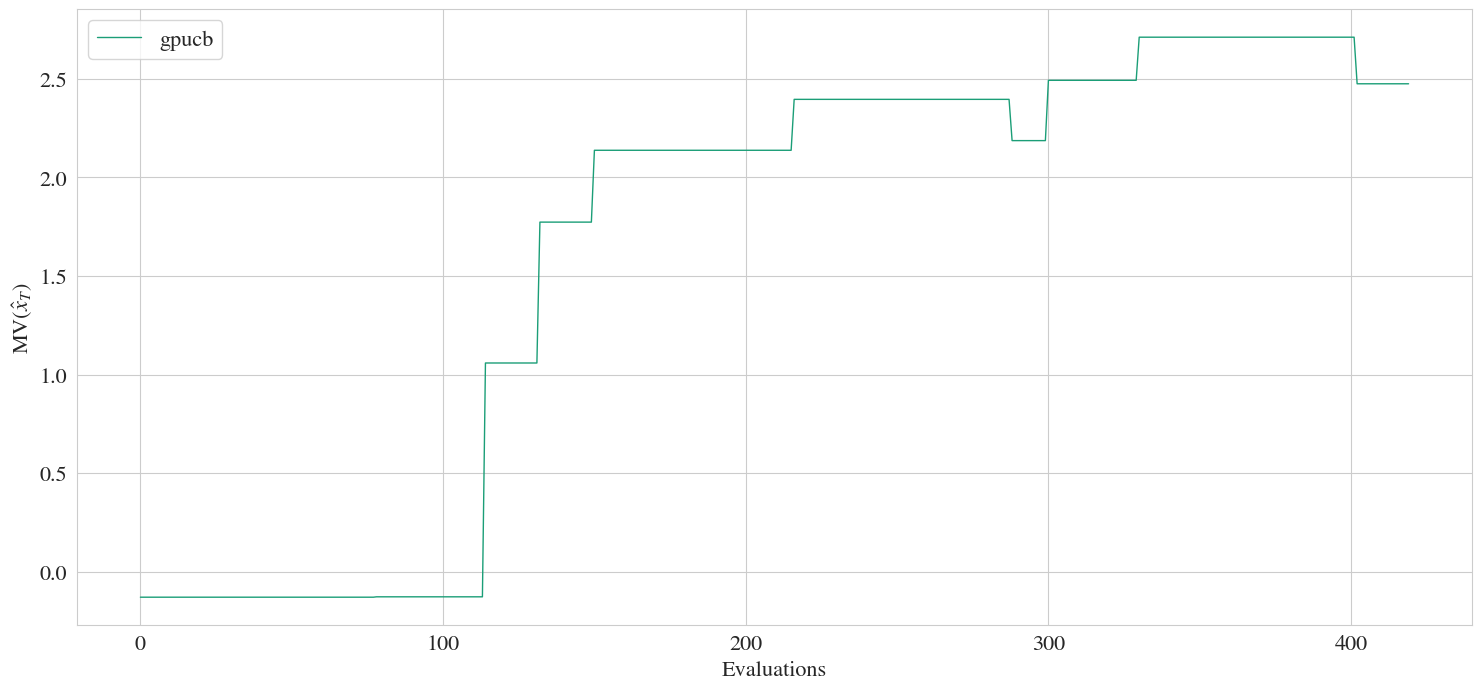

In [36]:
plot_objectives(objectives, objective_name='MV($\\hat{x}_T$)', x_label='Evaluations')

In [37]:
# objectives = {'gpucb': results['gpucb'][0]['scores'][results['gpucb'][0]['reporting_idx']],
#               'rahbo': results['rahbo'][0]['scores'][results['rahbo'][0]['reporting_idx']],
#               'erahbo': results['erahbo'][0]['scores'][results['erahbo'][0]['reporting_idx']]}
objectives = {'gpucb': results['gpucb'][0]['scores'][results['gpucb'][0]['reporting_idx']]}

(<Figure size 1800x800 with 1 Axes>,
 <AxesSubplot:xlabel='Evaluations', ylabel='f($\\hat{x}_T$)'>)

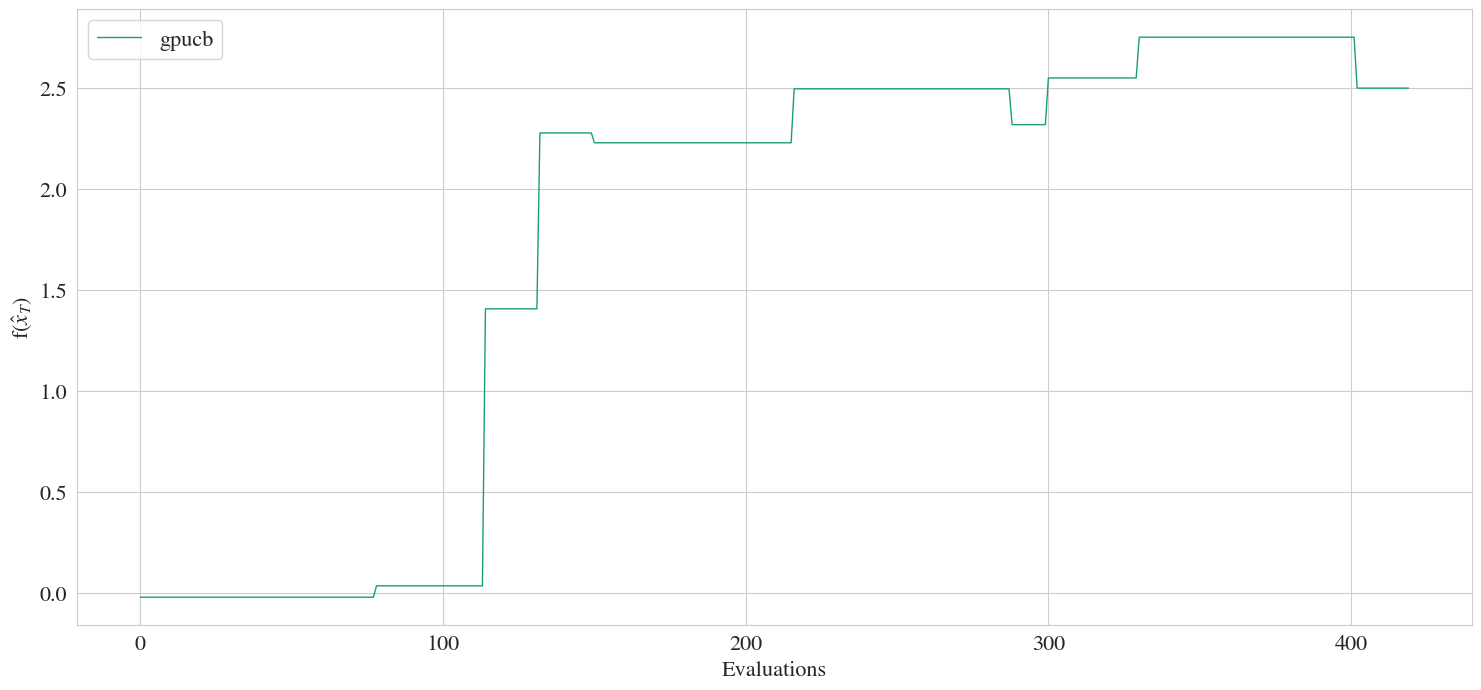

In [38]:
plot_objectives(objectives, objective_name='f($\\hat{x}_T$)', x_label='Evaluations')